In [0]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [0]:
# Paramters 
randomseed = 1
learningrate = 0.001
batchsize = 128
epochs = 10

# Architecture
features = 28*28
numberofclasses = 10

# Other
device = "cuda:0"
grayscale  = True

In [4]:
trainset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(),download=True)

testset = datasets.MNIST(root='data', train=False,  transform=transforms.ToTensor())


trainloader = DataLoader(dataset=trainset, batch_size=batchsize,  shuffle=True)

testloader = DataLoader(dataset=testset, batch_size=batchsize, shuffle=False)

# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [9]:
device1 = torch.device(device)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(trainloader):
        
        print('Epoch:', epoch+1, end='')
        print('batch index:', batch_idx, end='')
        print('batch size:', y.size()[0])
        
        x = x.to(device1)
        y = y.to(device1)
        break

Epoch: 1batch index: 0batch size: 128
Epoch: 2batch index: 0batch size: 128


In [0]:
def convolutionthreebythree(inplane, outplane, stride=1):
    return nn.Conv2d(inplane, outplane, kernel_size=3, stride=stride,
                     padding=1, bias=False)



In [0]:
class Block(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = convolutionthreebythree(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = convolutionthreebythree(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out


In [0]:
class ResNet(nn.Module):

    def __init__(self, block, layers, numclasses, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, numclasses)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet(numclass):
    model = ResNet(block=Block, 
                   layers=[2, 2, 2, 2],
                   numclasses=numberofclasses,
                   grayscale=grayscale)
    return model

In [0]:
torch.manual_seed(randomseed)

model = resnet(classes)
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=learningrate)

In [0]:
def accuracy(model, dataloader, device):
    pred, examples = 0, 0
    for i, (features, targets) in enumerate(dataloader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predictedlabels = torch.max(probas, 1)
        examples += targets.size(0)
        pred += (predictedlabels == targets).sum()
    return pred.float()/examples * 100

In [39]:
start = time.time()
for epoch in range(epochs):
    
    model.train()
    for batch_index, (features, targets) in enumerate(trainloader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        opt.zero_grad()
        
        cost.backward()
        
        opt.step()
        
        if not batch_index % 50:
            print ('Epoch: %03d/%03d - batch %04d/%04d - cost: %.4f' %(epoch+1, epochs, batch_index, len(trainloader), cost))

        
    model.eval()
    with torch.set_grad_enabled(False): 
        print('epoch: %03d/%03d | train: %.3f%%' % (epoch+1, epochs, accuracy(model, trainloader, device=device)))
        
    print('time: %.2f mins' % ((time.time() - start)/60))
    
print('total time: %.2f mins' % ((time.time() - start)/60))

Epoch: 001/010 - batch 0000/0469 - cost: 2.7026
Epoch: 001/010 - batch 0050/0469 - cost: 0.1255
Epoch: 001/010 - batch 0100/0469 - cost: 0.1206
Epoch: 001/010 - batch 0150/0469 - cost: 0.1369
Epoch: 001/010 - batch 0200/0469 - cost: 0.0970
Epoch: 001/010 - batch 0250/0469 - cost: 0.0494
Epoch: 001/010 - batch 0300/0469 - cost: 0.0208
Epoch: 001/010 - batch 0350/0469 - cost: 0.1080
Epoch: 001/010 - batch 0400/0469 - cost: 0.1061
Epoch: 001/010 - batch 0450/0469 - cost: 0.1741
epoch: 001/010 | train: 96.517%
time: 0.37 mins
Epoch: 002/010 - batch 0000/0469 - cost: 0.0311
Epoch: 002/010 - batch 0050/0469 - cost: 0.0221
Epoch: 002/010 - batch 0100/0469 - cost: 0.0302
Epoch: 002/010 - batch 0150/0469 - cost: 0.0587
Epoch: 002/010 - batch 0200/0469 - cost: 0.0412
Epoch: 002/010 - batch 0250/0469 - cost: 0.0448
Epoch: 002/010 - batch 0300/0469 - cost: 0.0763
Epoch: 002/010 - batch 0350/0469 - cost: 0.0203
Epoch: 002/010 - batch 0400/0469 - cost: 0.0261
Epoch: 002/010 - batch 0450/0469 - cost:

In [40]:
with torch.set_grad_enabled(False): 
    print('test accuracy: %.2f%%' % (accuracy(model, testloader, device=device)))

test accuracy: 99.06%


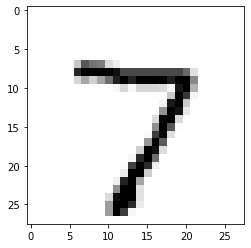

In [41]:
for batch_index, (features, targets) in enumerate(testloader):

    features = features
    targets = targets
    break
    

image = np.transpose(features[0], axes=(1, 2, 0))
image = np.squeeze(image.numpy(), axis=2)
plt.imshow(image, cmap='Greys');

In [44]:
model.eval()
logit, prob = model(features.to(device)[0, None])
print('Probability of being 7 %.2f%%' % (prob[0][7]*100))

Probability of being 7 99.98%
